# Data Understanding

## Import Dependencies

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
%matplotlib inline

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# laoding data
customer_table = pd.read_csv('/content/drive/MyDrive/Case Study Data Scientist/Customer.csv', sep=';')
product_table = pd.read_csv('/content/drive/MyDrive/Case Study Data Scientist/Product.csv', sep=';')
store_table = pd.read_csv('/content/drive/MyDrive/Case Study Data Scientist/Store.csv', sep=';')
transaction_table = pd.read_csv('/content/drive/MyDrive/Case Study Data Scientist/Transaction.csv', sep=';')

## Deskripsi Tabel

In [4]:
customer_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [5]:
product_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [6]:
store_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [7]:
transaction_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


# Data Preparation

In [8]:
# ubah tanggal transaksi menjadi format datetime
transaction_table['Date'] = pd.to_datetime(transaction_table['Date'], format='%d/%m/%Y')

## Menangani missing value

In [9]:
customer_table.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [10]:
product_table.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [11]:
store_table.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [12]:
transaction_table.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

Karena pada tabel customer, terdapat customer dengan marital status kosong, kita akan mengisinya dengan marital status yang paling sering muncul.

In [13]:
customer_table['Marital Status'].fillna(customer_table['Marital Status'].mode()[0], inplace=True)

In [14]:
customer_table.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

## Menggabungkan tabel

In [15]:
merged_data = pd.merge(transaction_table, product_table, on='ProductID', how='left')
merged_data = pd.merge(merged_data, store_table, on='StoreID', how='left')
merged_data = pd.merge(merged_data, customer_table, on='CustomerID', how='left')
merged_data.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,Married,"10,53"
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,10000,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,Married,"14,58"
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,Single,"0,18"
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,Married,"12,57"
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,10000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,Married,"6,95"


In [16]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  StoreName       5020 non-null   object        
 11  GroupStore      5020 non-null   object        
 12  Type            5020 non-null   object        
 13  Latitude        5020 non-null   object        
 14  Longitude       5020 non-null   object        
 15  Age 

## Membuat data baru untuk regresi

In [17]:
reg_data = transaction_table.groupby('Date')['Qty'].sum().reset_index()
reg_data['Date'] = pd.to_datetime(reg_data['Date'], format='%d/%m/%Y')
reg_data.sort_values(by='Date', inplace=True)
reg_data.set_index('Date', inplace=True)

In [18]:
len(reg_data)

365

## Visualisasi data

Plor jumlah penjualan harian sepanjang tahun

<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

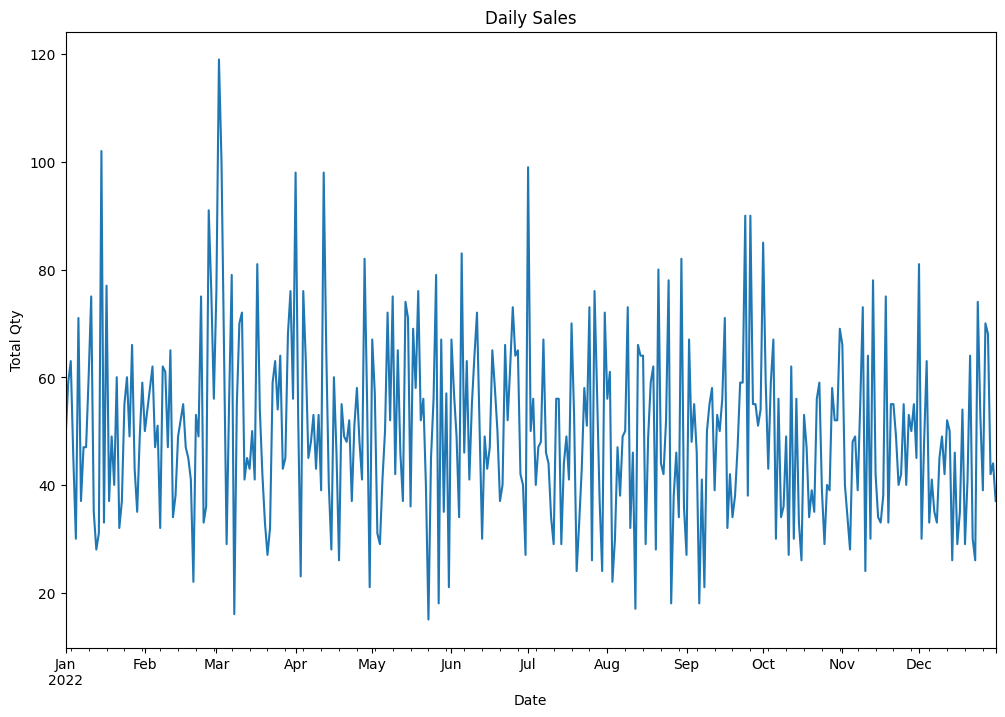

In [19]:
reg_data.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Qty', legend=False)

# Time Series Modeling

Sebelum melakukan pemodelan, kita akan melakukan dekomposisi untuk mengetahui apakah data memiliki komponen trend maupun musiman.

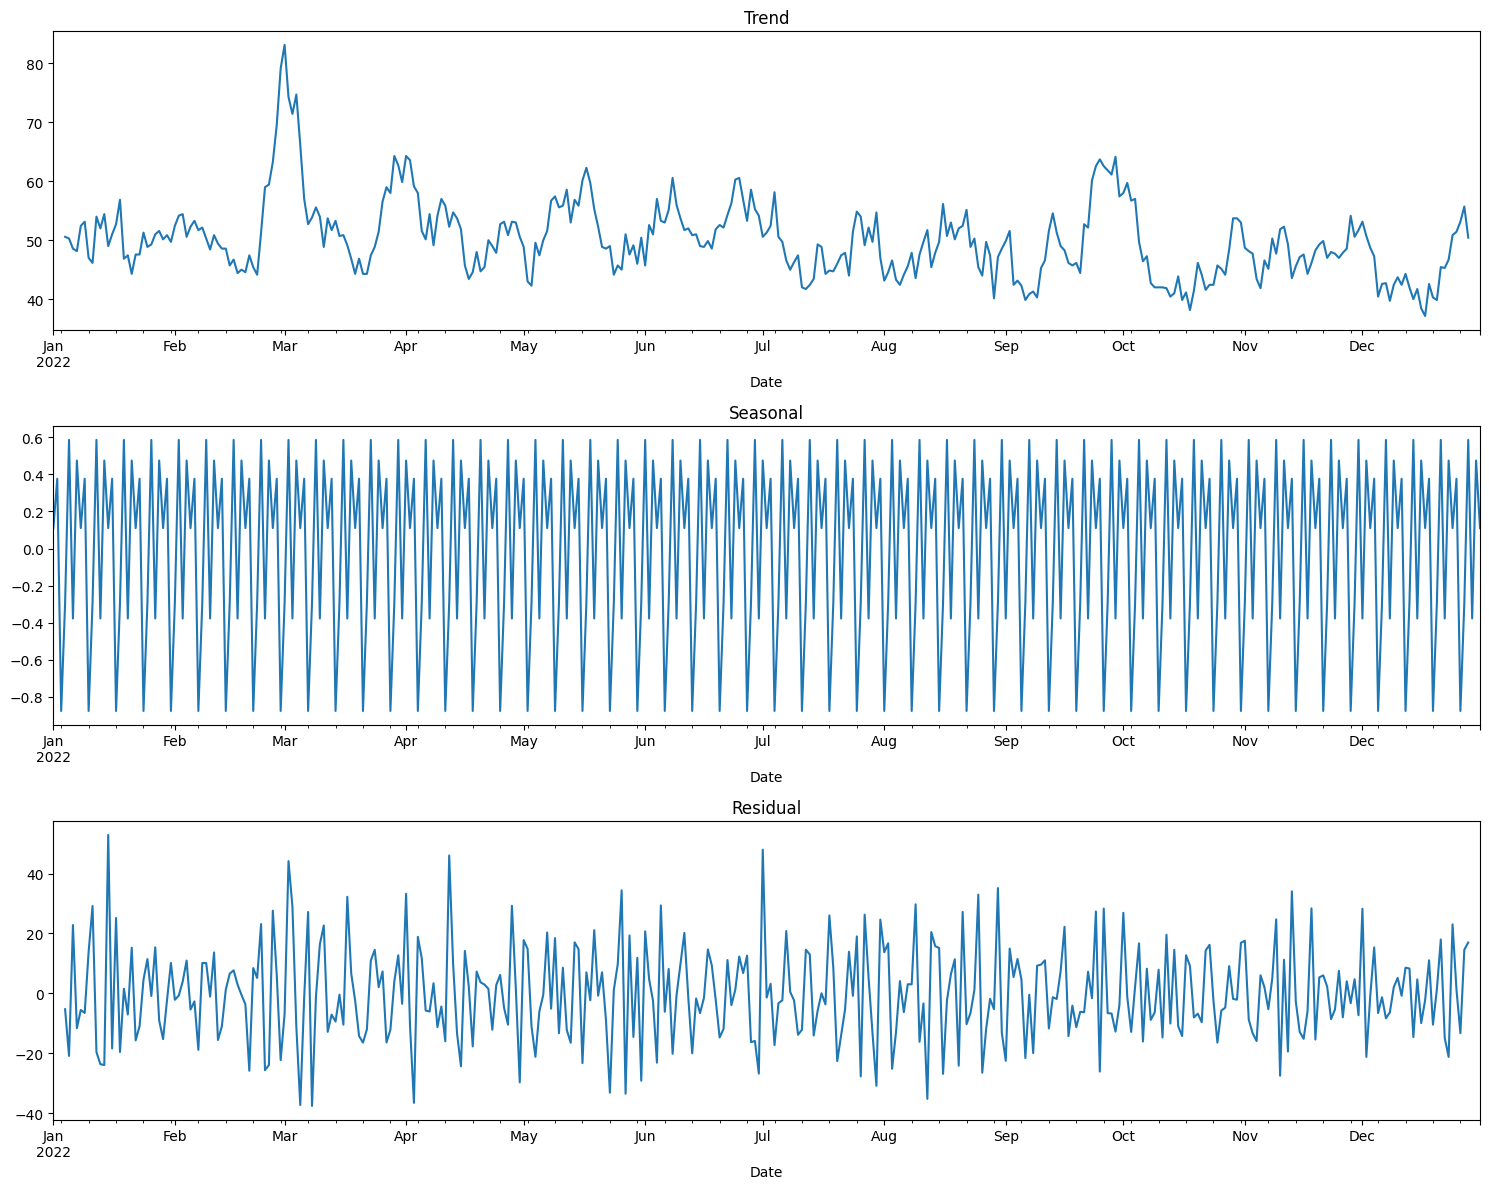

In [20]:
decompose = seasonal_decompose(reg_data)

fig,ax = plt.subplots(3,1,figsize=(15,12))
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.tight_layout()
plt.show()

Telihat dari plot data tersebut, terdapat pola musiman yaitu perulangan pola data pada bulan-bulan tertentu. Sementara itu, tidak terlalu terlihat pola trend atau kecenderungan data untuk naik atau turun seiring periode waktu.

## Cek stasioneritas data

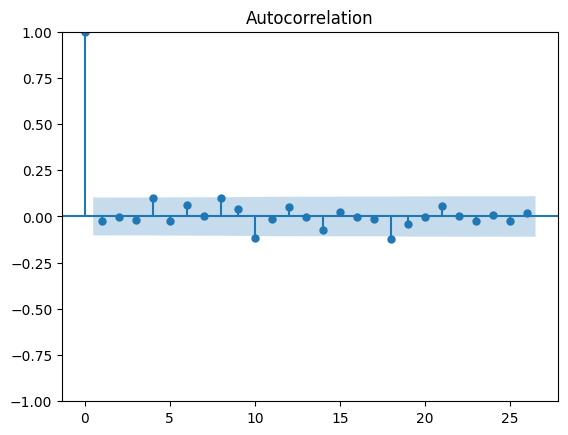

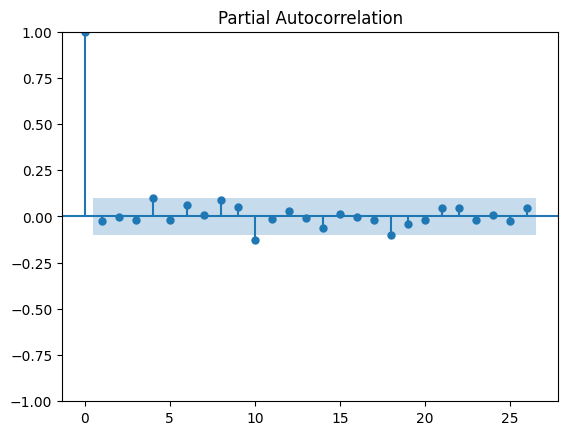

In [21]:
acf_original = plot_acf(reg_data)
pacf_original = plot_pacf(reg_data)

In [22]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(reg_data)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


Berdasarkan uji adfuller diketahui p-value = 0.00 < 0.05 maka kita bisa menentukan bahwa series tersebut sudah stasioner.

## Data splitting

Dilakukan pembagian data menjadi 80% data training dan 20% data testing

In [23]:
df_train = reg_data[:int(0.8*(len(reg_data)))]
df_test = reg_data[int(0.8*(len(reg_data))):]

## Pemodelan ARIMA

In [24]:
auto_arima_model = pm.auto_arima(
    df_train['Qty'],
    seasonal=False,
    stepwise=False,
    suppress_warnings=True,
    trace = True
)
auto_arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.26 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.40 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.67 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(3,0,0)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Sun, 01 Oct 2023   AIC                           2504.937
Time:                        06:20:22   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.556      0.000      -1.019      -0.961
sigma2       298.6887     22.254     13.422      0.000     255.072     342.306
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dari model auto arima dihasilkan model dengan parameter terbaik yaitu ARIMA(1,0,1). Jika dilihat dari plot data dan analisis sebelumnya, data memiliki pola musiman sehingga kita dapat memodelkannya dengan SARIMAX.

## Parameter Tuning ARIMA

In [37]:
from itertools import product
p = [40,50,60]
d = [2]
q = [1]
pdq = list(product(p, d, q))

In [50]:
aic_list = []

In [56]:
for param in pdq:
    model = ARIMA(df_train, order=param)
    model_fit = model.fit()
    aic_list.append({'par': param, 'aic': model_fit.aic})

best_aic = min(aic_list, key=lambda x: x['aic'])
print(best_aic)

{'par': (40, 1, 1), 'aic': 2528.1150559051575}


## Pemodelan SARIMAX

### Model Auto

In [61]:
p, d, q = auto_arima_model.order
model = SARIMAX(df_train['Qty'].values, order=(p,d,q))
model_fit = model.fit(disp=False)

In [62]:
from sklearn.metrics import mean_squared_error
predictions = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1)
rmse = mean_squared_error(df_test, predictions, squared=False)
rmse

14.153760587024204

### Tuned model

In [58]:
p, d, q = (40,1,1)
model_tuned = SARIMAX(df_train['Qty'].values, order=(p,d,q))
model_tuned_fit = model.fit(disp=False)

predictions = model_tuned_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1)
rmse = mean_squared_error(df_test, predictions, squared=False)
rmse

14.890766080661653

Jika dibandingkan, model terbaik merupakan model auto ML dengan RMSE yang lebih rendah.

## Peramalan penjualan untuk 90 hari kedepan

### Model auto

In [63]:
period = 90
forecast = model_fit.forecast(steps=period)
forecast_tuned = model_tuned_fit.forecast(steps=period)
index = pd.date_range(start='01-01-2023', periods=period)
df_forecast = pd.DataFrame(forecast, index=index, columns=['Qty'])
df_tuned_forecast = pd.DataFrame(forecast_tuned, index=index, columns=['Qty'])

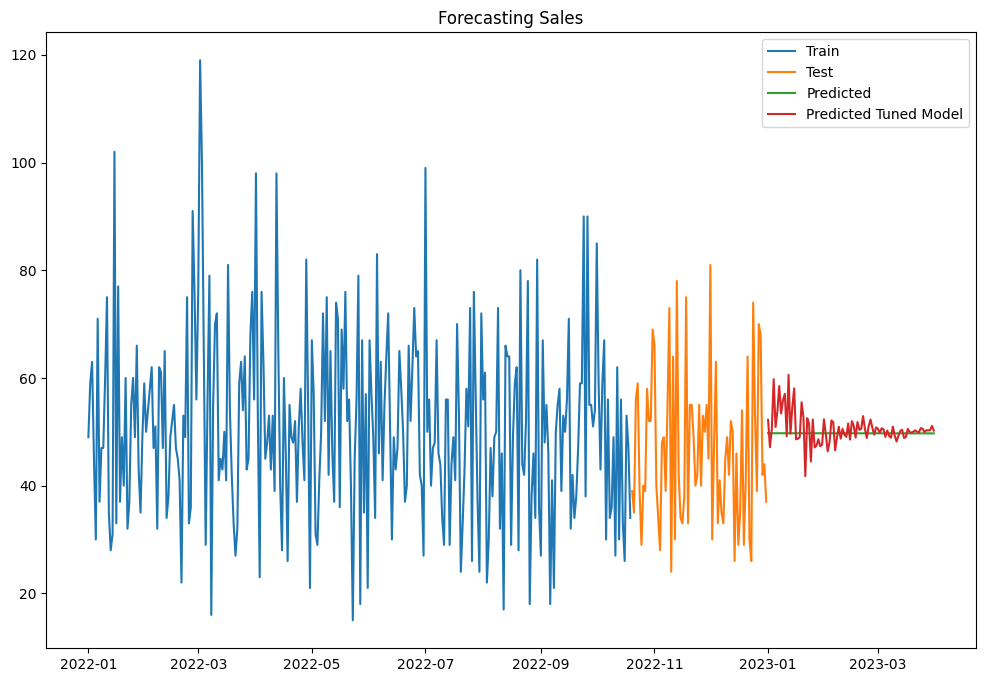

In [64]:
plt.figure(figsize=(12,8))
plt.title('Forecasting Sales')
plt.plot(df_train, label='Train')
plt.plot(df_test, label='Test')
plt.plot(df_forecast, label='Predicted')
plt.plot(df_tuned_forecast, label='Predicted Tuned Model')
plt.legend(loc='best')
plt.show()

In [70]:
df_forecast.astype(int)

,Qty
2023-01-01,49
2023-01-02,49
2023-01-03,49
2023-01-04,49
2023-01-05,49
...,...
2023-03-27,49
2023-03-28,49
2023-03-29,49
2023-03-30,49


In [71]:
df_forecast.describe()

,Qty
count,90.000000
mean,49.725501
std,0.007839
min,49.712150
25%,49.718825
50%,49.725500
75%,49.732177
max,49.738855


In [68]:
warnings.filterwarnings('ignore')

product_reg_df = merged_data[['Qty', 'Date', 'Product Name']]
new = product_reg_df.groupby("Product Name")

forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = SARIMAX(target_var.values, order=(p,d,q))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(90)
    forecast_product_df[product_name] = forecast.astype(int)

forecast_product_df.set_index('Date', inplace=True)
forecast_product_df

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-01,2,2,6,4,3,4,1,2,3,4
2023-01-02,2,2,6,4,3,4,1,2,3,4
2023-01-03,2,2,6,4,3,4,1,2,3,4
2023-01-04,2,2,6,4,3,4,1,2,3,4
2023-01-05,2,2,6,4,3,4,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...
2023-03-27,2,2,6,4,3,4,1,2,3,4
2023-03-28,2,2,6,4,3,4,1,2,3,4
2023-03-29,2,2,6,4,3,4,1,2,3,4


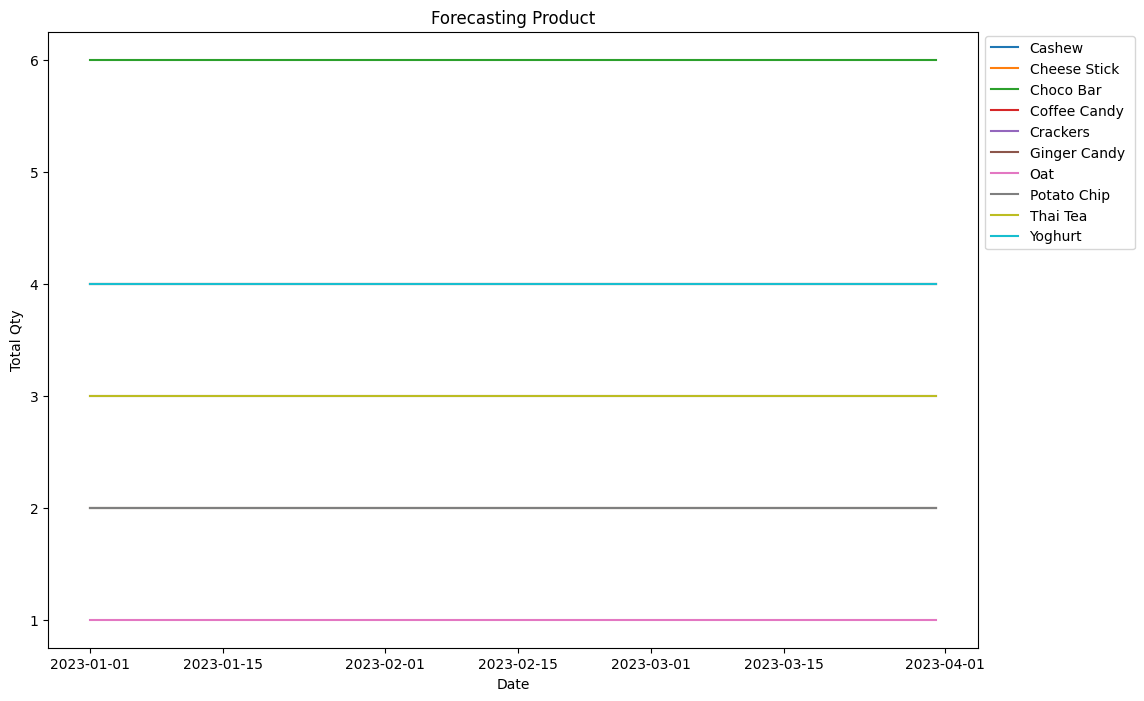

In [69]:
plt.figure(figsize=(12,8))
for i in forecast_product_df.columns:
    plt.plot(forecast_product_df[i], label=i)
plt.legend(loc=6, bbox_to_anchor=(1,.82))
plt.title('Forecasting Product')
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.show()